In [1]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.nn import functional as F
import time
from PIL import Image
import PIL
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from torchsummary import summary as model_summary
import glob
import nibabel as nib
import skimage
import sklearn
from sklearn import model_selection
import monai

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    Orientationd,
    Rand3DElasticd,
    RandAffined,
    Spacingd,
    Resized,
    NormalizeIntensityd,
    ToTensord,
    AsDiscrete,
)
from monai.config import print_config
from typing import Optional

from tqdm import tqdm
# from tqdm.notebook import tqdm

print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
print(f'torch.cuda.get_device_name(0): {torch.cuda.get_device_name(0)}')
print(f'torch.version.cuda: {torch.version.cuda}')
print(f'torch.cuda.device_count(): {torch.cuda.device_count()}')
print()
monai.config.print_config()

torch.cuda.is_available(): True
torch.cuda.get_device_name(0): NVIDIA GeForce RTX 3060
torch.version.cuda: 11.3
torch.cuda.device_count(): 1

MONAI version: 1.0.0
Numpy version: 1.22.3
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 170093375ce29267e45681fcec09dfa856e1d7e7
MONAI __file__: /home/kimbg/anaconda3/envs/test1/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.5.1
einops version: 0.5.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKN

## 구성
1. 데이터 불러오기
2. 데이터 체크(형태, 구조, 자료형 확인)
3. 데이터 전처리
    - minmax
    - resize 등
4. 2번 다시
5. 시각화

In [2]:
### HYPER PARAMETER ###

RANDOM_SEED = 831
IMAGE_SIZE = (128, 128, 128)
BATCH_SIZE = 2
NUM_CLASS = 2
EPOCHS = 200
test_ratio, val_ratio = 0.1, 0.2

MODEL_SAVE = True
if MODEL_SAVE:
    model_dir1 = '/data/MODEL_BG/'
    model_dir2 = 'Segmentation(3D)-UNETR(monai)'
    MODEL_SAVE_PATH = os.path.join(model_dir1, model_dir2)
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'

0. 데이터 준비
- 데이터가 있으면 `data_dir`를 자신의 경로에 맞게 수정해주세요.
- 데이터가 없으면 `USE_MY_DATA` 를 `False`로 두고 다운로드 받으면 됩니다.
- The dataset comes from http://medicaldecathlon.com/.

In [2]:
USE_MY_DATA = True

if not USE_MY_DATA:
    directory = os.environ.get("MONAI_DATA_DIRECTORY")
    root_dir = tempfile.mkdtemp() if directory is None else directory
    print(f"root dir is: {root_dir}")
    
    resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
    md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

    compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
    data_dir = os.path.join(root_dir, "Task09_Spleen")
    if not os.path.exists(data_dir):
        download_and_extract(resource, compressed_file, root_dir, md5)

else:
    data_dir = '/data/MSD/Task09_Spleen'

In [3]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]
train_data_dicts[0]

{'image': '/data/MSD/Task09_Spleen/imagesTr/spleen_10.nii.gz',
 'label': '/data/MSD/Task09_Spleen/labelsTr/spleen_10.nii.gz'}

1. 데이터 불러오기

In [3]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

TrainSet, TestSet = model_selection.train_test_split(data_dicts, test_size=test_ratio, random_state=RANDOM_SEED)
TrainSet, ValSet = model_selection.train_test_split(TrainSet, test_size=val_ratio, random_state=RANDOM_SEED)
print('TrainSet:', len(TrainSet), 'ValSet:', len(ValSet), 'TestSet:', len(TestSet))

img cnt: 41 ['/data/MSD/Task09_Spleen/imagesTr/spleen_10.nii.gz']
mask cn:; 41 ['/data/MSD/Task09_Spleen/labelsTr/spleen_10.nii.gz']
TrainSet: 28 ValSet: 8 TestSet: 5


2. 데이터 체크(형태, 구조, 자료형 확인)

In [4]:
for i in range(3):
    sample_img = nib.load(TrainSet[i]['image']).get_fdata()
    sample_mask = nib.load(TrainSet[i]['label']).get_fdata()
    print(f"[sample {i+1}] {os.path.basename(TrainSet[i]['image'])} {os.path.basename(TrainSet[i]['label'])}")
    print(sample_img.shape, sample_img.dtype, np.min(sample_img), np.max(sample_img))
    print(sample_mask.shape, sample_mask.dtype, np.unique(sample_mask))

[sample 1] spleen_2.nii.gz spleen_2.nii.gz
(512, 512, 90) float64 -1024.0 3071.0
(512, 512, 90) float64 [0. 1.]
[sample 2] spleen_19.nii.gz spleen_19.nii.gz
(512, 512, 51) float64 -1024.0 1372.0
(512, 512, 51) float64 [0. 1.]
[sample 3] spleen_17.nii.gz spleen_17.nii.gz
(512, 512, 95) float64 -1024.0 1964.0
(512, 512, 95) float64 [0. 1.]


3. 데이터 전처리
    - minmax
    - resize 등

In [5]:
from monai.transforms.compose import Transform, MapTransform

class MinMax(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] -= np.min(d[key])
            d[key] /= np.max(d[key])
        return d

loader = LoadImaged(keys=("image",'label'), image_only=False)
ensure_channel_first = EnsureChannelFirstd(keys=["image",'label'])
orientation = Orientationd(keys=["image",'label'], axcodes="RAS")
resize_img = Resized(keys=["image",], spatial_size=(IMAGE_SIZE), mode='trilinear')
resize_mask = Resized(keys=['label',], spatial_size=(IMAGE_SIZE), mode='nearest-exact')
# normalize = NormalizeIntensityd(keys=["image",])
minmax = MinMax(keys=['image',])

2. 데이터 체크(형태, 구조, 자료형 확인)

In [6]:
transforms = Compose([
    LoadImaged(keys=("image",'label'), image_only=False),
    EnsureChannelFirstd(keys=["image",'label']),
    Orientationd(keys=["image",'label'], axcodes="RAS"),
    Resized(keys=["image",], spatial_size=(IMAGE_SIZE), mode='trilinear'),
    Resized(keys=['label',], spatial_size=(IMAGE_SIZE), mode='nearest-exact'),
    # normalize = NormalizeIntensityd(keys=["image",])
    MinMax(keys=['image',]),
    ToTensord(keys=["image", "label"]),
    ])

SampleSet = transforms(TestSet[:3])

for i in range(3):
    sample_img = SampleSet[i]['image']
    sample_mask = SampleSet[i]['label']
    print(f"[sample {i+1}]")
    print(sample_img.shape, sample_img.dtype, torch.min(sample_img), torch.max(sample_img))
    print(sample_mask.shape, sample_mask.dtype, torch.unique(sample_mask))

[sample 1]
(1, 128, 128, 128) torch.float32 tensor(0.) tensor(1.)
(1, 128, 128, 128) torch.float32 tensor([0., 1.])
[sample 2]
(1, 128, 128, 128) torch.float32 tensor(0.) tensor(1.)
(1, 128, 128, 128) torch.float32 tensor([0., 1.])
[sample 3]
(1, 128, 128, 128) torch.float32 tensor(0.) tensor(1.)
(1, 128, 128, 128) torch.float32 tensor([0., 1.])


5. 시각화

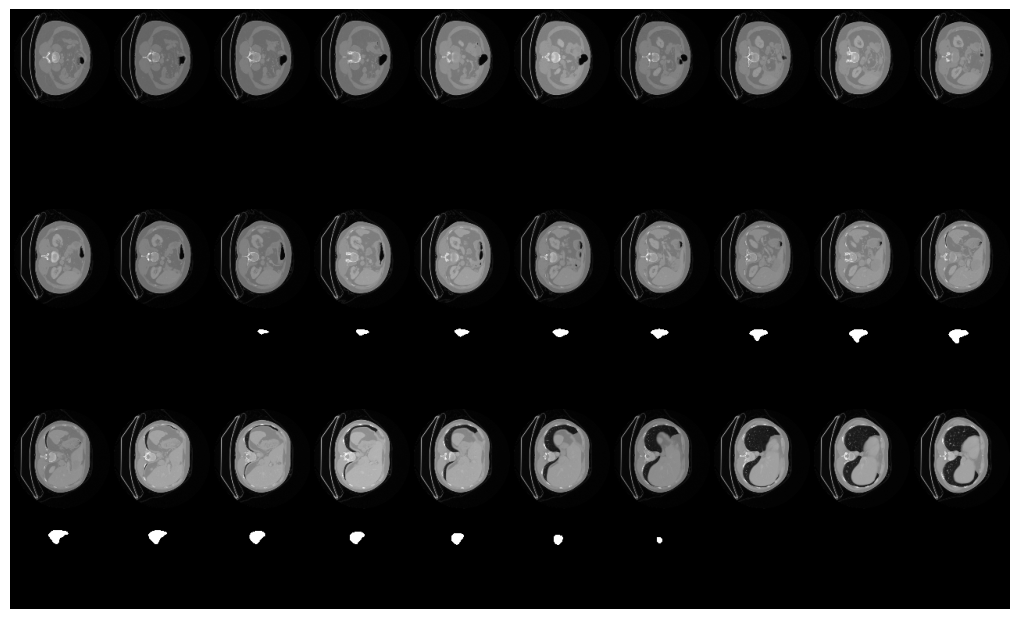

In [7]:
ncols, nrows = 10, 6
interval = int(IMAGE_SIZE[-1]//(ncols*nrows/2))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols,nrows))
cnt1, cnt2 = 0, 0
for i in range(nrows):
    for j in range(ncols):
        if i%2 == 0:
            axes[i,j].imshow(SampleSet[0]['image'][0,:,:,cnt1], cmap='gray')
            cnt1+=interval
        else:
            axes[i,j].imshow(SampleSet[0]['label'][0,:,:,cnt2], cmap='gray')
            cnt2+=interval
        axes[i,j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()  

6. Data pipeline build

In [8]:
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

train_ds = CacheDataset(
    data=TrainSet,
    transform=transforms,
    cache_num=4,
    cache_rate=1.0,
    num_workers=0)
val_ds = CacheDataset(
    data=ValSet, transform=transforms, cache_num=2, cache_rate=1.0, num_workers=0)
test_ds = CacheDataset(
    data=TestSet, transform=transforms, cache_num=2, cache_rate=1.0, num_workers=0)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

Loading dataset: 100%|███████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


7. model build

In [9]:
from monai.networks.nets import UNETR

model = UNETR(
    in_channels=1,
    out_channels=NUM_CLASS,
    img_size=IMAGE_SIZE,
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).float()
model = model.to(DEVICE)
# model_summary(model, (1,*IMAGE_SIZE), device=DEVICE.type)

8. optimizer, loss, metric 등 구성

In [10]:
from monai.losses import DiceCELoss, DiceLoss

torch.backends.cudnn.benchmark = True # ??

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

LossFuncion = monai.losses.DiceLoss(include_background=False, to_onehot_y=False, softmax=True)
MetricDice = monai.metrics.DiceMetric(include_background=False, reduction="mean")

In [11]:
def BinaryOutput(output, keepdim=True):
    shape = output.shape
    argmax_idx = torch.argmax(output, axis=1, keepdim=True)
    argmax_oh = F.one_hot(argmax_idx, num_classes=NUM_CLASS)
    if keepdim:
        argmax_oh = torch.squeeze(argmax_oh, dim=1)
    if len(shape) == 5:
        argmax_oh = argmax_oh.permute(0,4,1,2,3)
    elif len(shape) == 4:
        argmax_oh = argmax_oh.permute(0,3,1,2)
    
    return argmax_oh

9. train & evalute loop

In [12]:
from monai.losses.dice import DiceLoss, one_hot

def train(epoch, train_loader):
    model.train()
    mean_epoch_loss = 0
    mean_dice_score = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X EPOCHS) (loss=X.X) (dice score=%.5f)", 
        dynamic_ncols=True)
    
    for step, batch in enumerate(epoch_iterator):
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        y = torch.squeeze(y, dim=1)
        y = one_hot(y[:, None, ...], num_classes=NUM_CLASS)
        
        logit_map = model(x)
        loss = LossFuncion(logit_map, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        mean_epoch_loss += loss.item()
        
        bi_output = BinaryOutput(logit_map)
        MetricDice(bi_output, y)
        dice_score = MetricDice.aggregate().item()
        mean_dice_score += dice_score
        
        epoch_iterator.set_description(
            "Training (%d / %d EPOCHS) (loss=%2.5f) (dice score=%.5f)" 
            % (epoch, EPOCHS, loss, dice_score))
    
    mean_epoch_loss /= len(epoch_iterator)
    mean_dice_score /= len(epoch_iterator)
    
    return mean_epoch_loss, mean_dice_score



def evaluate(epoch, test_loader):
    model.eval() 
    mean_epoch_loss = 0
    mean_dice_score = 0
    epoch_iterator = tqdm(
        test_loader, desc="Evaluating (X / X EPOCHS) (loss=X.X) (dice score=%.5f)", 
        dynamic_ncols=True)
    
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator):
            x, y = (batch["image"].cuda(), batch["label"].cuda())
            y = torch.squeeze(y, dim=1)
            y = one_hot(y[:, None, ...], num_classes=NUM_CLASS)

            logit_map = model(x)
            loss = LossFuncion(logit_map, y)
            mean_epoch_loss += loss.item()

            bi_output = BinaryOutput(logit_map)
            MetricDice(bi_output, y)
            dice_score = MetricDice.aggregate().item()
            mean_dice_score += dice_score

            epoch_iterator.set_description(
                "Evaluating (%d / %d EPOCHS) (loss=%2.5f) (dice score=%.5f)" 
                % (epoch, EPOCHS, loss, dice_score))

    mean_epoch_loss /= len(epoch_iterator)
    mean_dice_score /= len(epoch_iterator)
    
    MetricDice.reset() # reset the status for next validation round
    
    return mean_epoch_loss, mean_dice_score    


10. let's training

In [ ]:
losses = {'train':[], 'val':[]}
dice_scores = {'train':[], 'val':[]}
best_metric, best_epoch = 999, -1

for epoch in range(1, EPOCHS+1):
    train_loss, train_dice_score = train(epoch, train_loader)
    val_loss, val_dice_score = evaluate(epoch, val_loader)
    
    losses['train'].append(train_loss)
    losses['val'].append(val_loss)
    dice_scores['train'].append(train_dice_score)
    dice_scores['val'].append(val_dice_score)

    if losses['val'][-1] < best_metric:
        best_metric = losses['val'][-1]
        best_epoch = epoch
        print(f'Best record! [{epoch}] Test Loss: {val_loss:.6f}, Dice score: {val_dice_score:.6f}')
        if MODEL_SAVE:
            model_name = f'{best_epoch}_{best_metric}.pth'
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, model_name))
            print('saved model')


Training (1 / 200 EPOCHS) (loss=0.98975) (dice score=0.02096): 100%|███████| 14/14 [00:30<00:00,  2.20s/it]
Evaluating (1 / 200 EPOCHS) (loss=0.98607) (dice score=0.02195): 100%|███████| 8/8 [00:04<00:00,  1.87it/s]


Best record! [1] Test Loss: 0.982468, Dice score: 0.021272
saved model


Training (2 / 200 EPOCHS) (loss=0.98127) (dice score=0.02355): 100%|███████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (2 / 200 EPOCHS) (loss=0.98417) (dice score=0.02473): 100%|███████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [2] Test Loss: 0.979773, Dice score: 0.023946
saved model


Training (3 / 200 EPOCHS) (loss=0.98419) (dice score=0.02973): 100%|███████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (3 / 200 EPOCHS) (loss=0.98136) (dice score=0.03251): 100%|███████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [3] Test Loss: 0.976199, Dice score: 0.030969
saved model


Training (4 / 200 EPOCHS) (loss=0.96905) (dice score=0.04505): 100%|███████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (4 / 200 EPOCHS) (loss=0.97745) (dice score=0.05157): 100%|███████| 8/8 [00:03<00:00,  2.14it/s]


Best record! [4] Test Loss: 0.971966, Dice score: 0.048109
saved model


Training (5 / 200 EPOCHS) (loss=0.98320) (dice score=0.08742): 100%|███████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (5 / 200 EPOCHS) (loss=0.97347) (dice score=0.09619): 100%|███████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [5] Test Loss: 0.967286, Dice score: 0.091262
saved model


Training (6 / 200 EPOCHS) (loss=0.97953) (dice score=0.12782): 100%|███████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (6 / 200 EPOCHS) (loss=0.97278) (dice score=0.12933): 100%|███████| 8/8 [00:03<00:00,  2.17it/s]


Best record! [6] Test Loss: 0.966226, Dice score: 0.126807
saved model


Training (7 / 200 EPOCHS) (loss=0.98290) (dice score=0.14829): 100%|███████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (7 / 200 EPOCHS) (loss=0.97067) (dice score=0.15250): 100%|███████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [7] Test Loss: 0.964148, Dice score: 0.148708
saved model


Training (8 / 200 EPOCHS) (loss=0.97352) (dice score=0.14926): 100%|███████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (8 / 200 EPOCHS) (loss=0.96910) (dice score=0.16002): 100%|███████| 8/8 [00:03<00:00,  2.15it/s]
Training (9 / 200 EPOCHS) (loss=0.95743) (dice score=0.16949): 100%|███████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (9 / 200 EPOCHS) (loss=0.96803) (dice score=0.17364): 100%|███████| 8/8 [00:03<00:00,  2.14it/s]


Best record! [9] Test Loss: 0.961823, Dice score: 0.169467
saved model


Training (10 / 200 EPOCHS) (loss=0.94387) (dice score=0.18765): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (10 / 200 EPOCHS) (loss=0.96686) (dice score=0.19338): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [10] Test Loss: 0.959405, Dice score: 0.188851
saved model


Training (11 / 200 EPOCHS) (loss=0.92992) (dice score=0.19977): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (11 / 200 EPOCHS) (loss=0.96634) (dice score=0.20178): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [11] Test Loss: 0.958361, Dice score: 0.198550
saved model


Training (12 / 200 EPOCHS) (loss=0.97349) (dice score=0.23883): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (12 / 200 EPOCHS) (loss=0.96445) (dice score=0.24100): 100%|██████| 8/8 [00:03<00:00,  2.13it/s]


Best record! [12] Test Loss: 0.956269, Dice score: 0.237200
saved model


Training (13 / 200 EPOCHS) (loss=0.97580) (dice score=0.24007): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (13 / 200 EPOCHS) (loss=0.96507) (dice score=0.23057): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]


Best record! [13] Test Loss: 0.956062, Dice score: 0.231543
saved model


Training (14 / 200 EPOCHS) (loss=0.94476) (dice score=0.23005): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (14 / 200 EPOCHS) (loss=0.96134) (dice score=0.23646): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [14] Test Loss: 0.954755, Dice score: 0.229872
saved model


Training (15 / 200 EPOCHS) (loss=0.93523) (dice score=0.26390): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (15 / 200 EPOCHS) (loss=0.95953) (dice score=0.27989): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]


Best record! [15] Test Loss: 0.953591, Dice score: 0.269466
saved model


Training (16 / 200 EPOCHS) (loss=0.97697) (dice score=0.31832): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (16 / 200 EPOCHS) (loss=0.95827) (dice score=0.32675): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]
Training (17 / 200 EPOCHS) (loss=0.95092) (dice score=0.33779): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (17 / 200 EPOCHS) (loss=0.95684) (dice score=0.34073): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [17] Test Loss: 0.949450, Dice score: 0.336316
saved model


Training (18 / 200 EPOCHS) (loss=0.97022) (dice score=0.32082): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (18 / 200 EPOCHS) (loss=0.95562) (dice score=0.31873): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [18] Test Loss: 0.948003, Dice score: 0.315484
saved model


Training (19 / 200 EPOCHS) (loss=0.97002) (dice score=0.33271): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (19 / 200 EPOCHS) (loss=0.95525) (dice score=0.31648): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [19] Test Loss: 0.946654, Dice score: 0.319009
saved model


Training (20 / 200 EPOCHS) (loss=0.96310) (dice score=0.31088): 100%|██████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (20 / 200 EPOCHS) (loss=0.95284) (dice score=0.31837): 100%|██████| 8/8 [00:03<00:00,  2.18it/s]


Best record! [20] Test Loss: 0.946062, Dice score: 0.310809
saved model


Training (21 / 200 EPOCHS) (loss=0.94396) (dice score=0.35456): 100%|██████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (21 / 200 EPOCHS) (loss=0.95124) (dice score=0.34871): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]


Best record! [21] Test Loss: 0.943334, Dice score: 0.347234
saved model


Training (22 / 200 EPOCHS) (loss=0.90224) (dice score=0.37416): 100%|██████| 14/14 [00:24<00:00,  1.79s/it]
Evaluating (22 / 200 EPOCHS) (loss=0.94988) (dice score=0.36937): 100%|██████| 8/8 [00:03<00:00,  2.13it/s]


Best record! [22] Test Loss: 0.943064, Dice score: 0.366346
saved model


Training (23 / 200 EPOCHS) (loss=0.96675) (dice score=0.35070): 100%|██████| 14/14 [00:25<00:00,  1.83s/it]
Evaluating (23 / 200 EPOCHS) (loss=0.94711) (dice score=0.33728): 100%|██████| 8/8 [00:03<00:00,  2.10it/s]


Best record! [23] Test Loss: 0.939521, Dice score: 0.338294
saved model


Training (24 / 200 EPOCHS) (loss=0.96977) (dice score=0.38201): 100%|██████| 14/14 [00:25<00:00,  1.84s/it]
Evaluating (24 / 200 EPOCHS) (loss=0.94316) (dice score=0.37741): 100%|██████| 8/8 [00:03<00:00,  2.09it/s]


Best record! [24] Test Loss: 0.936117, Dice score: 0.374855
saved model


Training (25 / 200 EPOCHS) (loss=0.95289) (dice score=0.41336): 100%|██████| 14/14 [00:25<00:00,  1.83s/it]
Evaluating (25 / 200 EPOCHS) (loss=0.94268) (dice score=0.40784): 100%|██████| 8/8 [00:03<00:00,  2.10it/s]
Training (26 / 200 EPOCHS) (loss=0.95566) (dice score=0.40782): 100%|██████| 14/14 [00:25<00:00,  1.83s/it]
Evaluating (26 / 200 EPOCHS) (loss=0.94088) (dice score=0.40430): 100%|██████| 8/8 [00:03<00:00,  2.12it/s]


Best record! [26] Test Loss: 0.935785, Dice score: 0.399373
saved model


Training (27 / 200 EPOCHS) (loss=0.95594) (dice score=0.43654): 100%|██████| 14/14 [00:25<00:00,  1.82s/it]
Evaluating (27 / 200 EPOCHS) (loss=0.93898) (dice score=0.43395): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]


Best record! [27] Test Loss: 0.931213, Dice score: 0.430519
saved model


Training (28 / 200 EPOCHS) (loss=0.96203) (dice score=0.43867): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (28 / 200 EPOCHS) (loss=0.93694) (dice score=0.42182): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [28] Test Loss: 0.925279, Dice score: 0.424935
saved model


Training (29 / 200 EPOCHS) (loss=0.93433) (dice score=0.44604): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (29 / 200 EPOCHS) (loss=0.93427) (dice score=0.43660): 100%|██████| 8/8 [00:03<00:00,  2.18it/s]
Training (30 / 200 EPOCHS) (loss=0.89492) (dice score=0.42168): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (30 / 200 EPOCHS) (loss=0.93371) (dice score=0.40852): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]
Training (31 / 200 EPOCHS) (loss=0.92176) (dice score=0.45139): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (31 / 200 EPOCHS) (loss=0.92970) (dice score=0.44232): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]


Best record! [31] Test Loss: 0.922828, Dice score: 0.440221
saved model


Training (32 / 200 EPOCHS) (loss=0.90976) (dice score=0.44594): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (32 / 200 EPOCHS) (loss=0.92665) (dice score=0.43504): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [32] Test Loss: 0.916485, Dice score: 0.434668
saved model


Training (33 / 200 EPOCHS) (loss=0.91083) (dice score=0.45245): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (33 / 200 EPOCHS) (loss=0.92636) (dice score=0.44217): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]
Training (34 / 200 EPOCHS) (loss=0.92511) (dice score=0.49230): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (34 / 200 EPOCHS) (loss=0.91832) (dice score=0.48039): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [34] Test Loss: 0.913525, Dice score: 0.479241
saved model


Training (35 / 200 EPOCHS) (loss=0.92359) (dice score=0.41810): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (35 / 200 EPOCHS) (loss=0.92529) (dice score=0.40638): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]
Training (36 / 200 EPOCHS) (loss=0.95373) (dice score=0.43829): 100%|██████| 14/14 [00:24<00:00,  1.79s/it]
Evaluating (36 / 200 EPOCHS) (loss=0.92273) (dice score=0.42982): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]
Training (37 / 200 EPOCHS) (loss=0.92853) (dice score=0.39565): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (37 / 200 EPOCHS) (loss=0.91810) (dice score=0.41135): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [37] Test Loss: 0.911240, Dice score: 0.400235
saved model


Training (38 / 200 EPOCHS) (loss=0.90917) (dice score=0.43685): 100%|██████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (38 / 200 EPOCHS) (loss=0.90658) (dice score=0.43267): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [38] Test Loss: 0.905055, Dice score: 0.428697
saved model


Training (39 / 200 EPOCHS) (loss=0.90568) (dice score=0.45726): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (39 / 200 EPOCHS) (loss=0.91088) (dice score=0.43375): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]


Best record! [39] Test Loss: 0.897403, Dice score: 0.438628
saved model


Training (40 / 200 EPOCHS) (loss=0.93767) (dice score=0.44138): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (40 / 200 EPOCHS) (loss=0.89746) (dice score=0.43259): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]


Best record! [40] Test Loss: 0.890867, Dice score: 0.431799
saved model


Training (41 / 200 EPOCHS) (loss=0.83312) (dice score=0.47682): 100%|██████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (41 / 200 EPOCHS) (loss=0.89593) (dice score=0.45404): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]
Training (42 / 200 EPOCHS) (loss=0.81832) (dice score=0.47586): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (42 / 200 EPOCHS) (loss=0.89534) (dice score=0.46646): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [42] Test Loss: 0.889677, Dice score: 0.464078
saved model


Training (43 / 200 EPOCHS) (loss=0.85747) (dice score=0.51280): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (43 / 200 EPOCHS) (loss=0.88609) (dice score=0.49958): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [43] Test Loss: 0.881936, Dice score: 0.499978
saved model


Training (44 / 200 EPOCHS) (loss=0.91575) (dice score=0.54775): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (44 / 200 EPOCHS) (loss=0.89117) (dice score=0.51873): 100%|██████| 8/8 [00:03<00:00,  2.18it/s]
Training (45 / 200 EPOCHS) (loss=0.82913) (dice score=0.56228): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (45 / 200 EPOCHS) (loss=0.88136) (dice score=0.53187): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [45] Test Loss: 0.878021, Dice score: 0.537901
saved model


Training (46 / 200 EPOCHS) (loss=0.87403) (dice score=0.55610): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (46 / 200 EPOCHS) (loss=0.87839) (dice score=0.53451): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]


Best record! [46] Test Loss: 0.873040, Dice score: 0.537820
saved model


Training (47 / 200 EPOCHS) (loss=0.86546) (dice score=0.59582): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (47 / 200 EPOCHS) (loss=0.87097) (dice score=0.57067): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]
Training (48 / 200 EPOCHS) (loss=0.89150) (dice score=0.61708): 100%|██████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (48 / 200 EPOCHS) (loss=0.86939) (dice score=0.58969): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [48] Test Loss: 0.867646, Dice score: 0.594883
saved model


Training (49 / 200 EPOCHS) (loss=0.83408) (dice score=0.62890): 100%|██████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (49 / 200 EPOCHS) (loss=0.86215) (dice score=0.59056): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [49] Test Loss: 0.861665, Dice score: 0.599808
saved model


Training (50 / 200 EPOCHS) (loss=0.82127) (dice score=0.61038): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (50 / 200 EPOCHS) (loss=0.84991) (dice score=0.58523): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]


Best record! [50] Test Loss: 0.855174, Dice score: 0.589596
saved model


Training (51 / 200 EPOCHS) (loss=0.78836) (dice score=0.62303): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (51 / 200 EPOCHS) (loss=0.85301) (dice score=0.59384): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [51] Test Loss: 0.848887, Dice score: 0.600515
saved model


Training (52 / 200 EPOCHS) (loss=0.82285) (dice score=0.62029): 100%|██████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (52 / 200 EPOCHS) (loss=0.84501) (dice score=0.58370): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [52] Test Loss: 0.841325, Dice score: 0.592475
saved model


Training (53 / 200 EPOCHS) (loss=0.79331) (dice score=0.63331): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (53 / 200 EPOCHS) (loss=0.84119) (dice score=0.60474): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]
Training (54 / 200 EPOCHS) (loss=0.89963) (dice score=0.63213): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (54 / 200 EPOCHS) (loss=0.83487) (dice score=0.60731): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [54] Test Loss: 0.841260, Dice score: 0.612566
saved model


Training (55 / 200 EPOCHS) (loss=0.77729) (dice score=0.66616): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (55 / 200 EPOCHS) (loss=0.82618) (dice score=0.63288): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]


Best record! [55] Test Loss: 0.838226, Dice score: 0.640295
saved model


Training (56 / 200 EPOCHS) (loss=0.76692) (dice score=0.64513): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (56 / 200 EPOCHS) (loss=0.83378) (dice score=0.61803): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [56] Test Loss: 0.833914, Dice score: 0.624018
saved model


Training (57 / 200 EPOCHS) (loss=0.77802) (dice score=0.68115): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (57 / 200 EPOCHS) (loss=0.80303) (dice score=0.64719): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [57] Test Loss: 0.817109, Dice score: 0.655184
saved model


Training (58 / 200 EPOCHS) (loss=0.78245) (dice score=0.67707): 100%|██████| 14/14 [00:25<00:00,  1.80s/it]
Evaluating (58 / 200 EPOCHS) (loss=0.81690) (dice score=0.65036): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [58] Test Loss: 0.813608, Dice score: 0.656124
saved model


Training (59 / 200 EPOCHS) (loss=0.71973) (dice score=0.67836): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (59 / 200 EPOCHS) (loss=0.83090) (dice score=0.63609): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]
Training (60 / 200 EPOCHS) (loss=0.71025) (dice score=0.70754): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (60 / 200 EPOCHS) (loss=0.79472) (dice score=0.66662): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [60] Test Loss: 0.807141, Dice score: 0.677426
saved model


Training (61 / 200 EPOCHS) (loss=0.74439) (dice score=0.67130): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (61 / 200 EPOCHS) (loss=0.77806) (dice score=0.62728): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [61] Test Loss: 0.799824, Dice score: 0.638360
saved model


Training (62 / 200 EPOCHS) (loss=0.69951) (dice score=0.67910): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (62 / 200 EPOCHS) (loss=0.78255) (dice score=0.64614): 100%|██████| 8/8 [00:03<00:00,  2.13it/s]
Training (63 / 200 EPOCHS) (loss=0.78890) (dice score=0.69947): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (63 / 200 EPOCHS) (loss=0.77642) (dice score=0.66141): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]
Training (64 / 200 EPOCHS) (loss=0.66995) (dice score=0.71020): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (64 / 200 EPOCHS) (loss=0.76678) (dice score=0.66758): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]


Best record! [64] Test Loss: 0.782221, Dice score: 0.677453
saved model


Training (65 / 200 EPOCHS) (loss=0.77763) (dice score=0.70753): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (65 / 200 EPOCHS) (loss=0.77359) (dice score=0.66918): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]
Training (66 / 200 EPOCHS) (loss=0.75141) (dice score=0.74003): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (66 / 200 EPOCHS) (loss=0.74447) (dice score=0.69766): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [66] Test Loss: 0.759219, Dice score: 0.708922
saved model


Training (67 / 200 EPOCHS) (loss=0.66807) (dice score=0.73381): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (67 / 200 EPOCHS) (loss=0.75453) (dice score=0.68671): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]
Training (68 / 200 EPOCHS) (loss=0.75762) (dice score=0.75520): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (68 / 200 EPOCHS) (loss=0.76178) (dice score=0.70683): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]
Training (69 / 200 EPOCHS) (loss=0.66576) (dice score=0.77372): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (69 / 200 EPOCHS) (loss=0.74093) (dice score=0.71884): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [69] Test Loss: 0.758270, Dice score: 0.733907
saved model


Training (70 / 200 EPOCHS) (loss=0.71509) (dice score=0.77676): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (70 / 200 EPOCHS) (loss=0.71448) (dice score=0.73527): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]


Best record! [70] Test Loss: 0.737286, Dice score: 0.745211
saved model


Training (71 / 200 EPOCHS) (loss=0.61380) (dice score=0.80613): 100%|██████| 14/14 [00:24<00:00,  1.79s/it]
Evaluating (71 / 200 EPOCHS) (loss=0.71771) (dice score=0.74448): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]
Training (72 / 200 EPOCHS) (loss=0.71510) (dice score=0.80531): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (72 / 200 EPOCHS) (loss=0.73296) (dice score=0.75088): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]
Training (73 / 200 EPOCHS) (loss=0.66595) (dice score=0.81935): 100%|██████| 14/14 [00:24<00:00,  1.79s/it]
Evaluating (73 / 200 EPOCHS) (loss=0.70653) (dice score=0.75835): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]


Best record! [73] Test Loss: 0.730516, Dice score: 0.776704
saved model


Training (74 / 200 EPOCHS) (loss=0.63131) (dice score=0.80941): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (74 / 200 EPOCHS) (loss=0.70913) (dice score=0.75950): 100%|██████| 8/8 [00:03<00:00,  2.13it/s]


Best record! [74] Test Loss: 0.726592, Dice score: 0.773635
saved model


Training (75 / 200 EPOCHS) (loss=0.60335) (dice score=0.80465): 100%|██████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (75 / 200 EPOCHS) (loss=0.69079) (dice score=0.74880): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [75] Test Loss: 0.724417, Dice score: 0.763693
saved model


Training (76 / 200 EPOCHS) (loss=0.59209) (dice score=0.82064): 100%|██████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (76 / 200 EPOCHS) (loss=0.66622) (dice score=0.76378): 100%|██████| 8/8 [00:03<00:00,  2.13it/s]


Best record! [76] Test Loss: 0.710571, Dice score: 0.779756
saved model


Training (77 / 200 EPOCHS) (loss=0.70923) (dice score=0.81856): 100%|██████| 14/14 [00:25<00:00,  1.81s/it]
Evaluating (77 / 200 EPOCHS) (loss=0.65627) (dice score=0.76800): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]


Best record! [77] Test Loss: 0.703552, Dice score: 0.781549
saved model


Training (78 / 200 EPOCHS) (loss=0.48232) (dice score=0.83634): 100%|██████| 14/14 [00:25<00:00,  1.80s/it]
Evaluating (78 / 200 EPOCHS) (loss=0.66067) (dice score=0.77730): 100%|██████| 8/8 [00:03<00:00,  2.18it/s]
Training (79 / 200 EPOCHS) (loss=0.51003) (dice score=0.83769): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (79 / 200 EPOCHS) (loss=0.64020) (dice score=0.77429): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]


Best record! [79] Test Loss: 0.688363, Dice score: 0.791639
saved model


Training (80 / 200 EPOCHS) (loss=0.61792) (dice score=0.81628): 100%|██████| 14/14 [00:25<00:00,  1.80s/it]
Evaluating (80 / 200 EPOCHS) (loss=0.64839) (dice score=0.76417): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]
Training (81 / 200 EPOCHS) (loss=0.46529) (dice score=0.82193): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (81 / 200 EPOCHS) (loss=0.62489) (dice score=0.76296): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [81] Test Loss: 0.668023, Dice score: 0.779082
saved model


Training (82 / 200 EPOCHS) (loss=0.56944) (dice score=0.83647): 100%|██████| 14/14 [00:25<00:00,  1.80s/it]
Evaluating (82 / 200 EPOCHS) (loss=0.65138) (dice score=0.77496): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]
Training (83 / 200 EPOCHS) (loss=0.52792) (dice score=0.86291): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (83 / 200 EPOCHS) (loss=0.59407) (dice score=0.80150): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]


Best record! [83] Test Loss: 0.659713, Dice score: 0.818240
saved model


Training (84 / 200 EPOCHS) (loss=0.67888) (dice score=0.85359): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (84 / 200 EPOCHS) (loss=0.64418) (dice score=0.79177): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]
Training (85 / 200 EPOCHS) (loss=0.57908) (dice score=0.85498): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (85 / 200 EPOCHS) (loss=0.60309) (dice score=0.79970): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [85] Test Loss: 0.646053, Dice score: 0.814174
saved model


Training (86 / 200 EPOCHS) (loss=0.53265) (dice score=0.86092): 100%|██████| 14/14 [00:25<00:00,  1.80s/it]
Evaluating (86 / 200 EPOCHS) (loss=0.59830) (dice score=0.79785): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]
Training (87 / 200 EPOCHS) (loss=0.51193) (dice score=0.87612): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (87 / 200 EPOCHS) (loss=0.57897) (dice score=0.80998): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]
Training (88 / 200 EPOCHS) (loss=0.35821) (dice score=0.87516): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (88 / 200 EPOCHS) (loss=0.59850) (dice score=0.80349): 100%|██████| 8/8 [00:03<00:00,  2.11it/s]
Training (89 / 200 EPOCHS) (loss=0.51198) (dice score=0.88320): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (89 / 200 EPOCHS) (loss=0.58047) (dice score=0.81128): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]
Training (90 / 200 EPOCHS) (loss=0.54998) (dice score=0.87965): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (90 / 200 EPOCHS)

Best record! [92] Test Loss: 0.613454, Dice score: 0.841224
saved model


Training (93 / 200 EPOCHS) (loss=0.48909) (dice score=0.88959): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (93 / 200 EPOCHS) (loss=0.55206) (dice score=0.81547): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]
Training (94 / 200 EPOCHS) (loss=0.45394) (dice score=0.89579): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (94 / 200 EPOCHS) (loss=0.53626) (dice score=0.82738): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [94] Test Loss: 0.608217, Dice score: 0.846217
saved model


Training (95 / 200 EPOCHS) (loss=0.42548) (dice score=0.89402): 100%|██████| 14/14 [00:25<00:00,  1.80s/it]
Evaluating (95 / 200 EPOCHS) (loss=0.50665) (dice score=0.82675): 100%|██████| 8/8 [00:03<00:00,  2.14it/s]


Best record! [95] Test Loss: 0.605929, Dice score: 0.843925
saved model


Training (96 / 200 EPOCHS) (loss=0.41630) (dice score=0.89999): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (96 / 200 EPOCHS) (loss=0.54184) (dice score=0.82026): 100%|██████| 8/8 [00:03<00:00,  2.17it/s]
Training (97 / 200 EPOCHS) (loss=0.38848) (dice score=0.90188): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (97 / 200 EPOCHS) (loss=0.51803) (dice score=0.84023): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [97] Test Loss: 0.588130, Dice score: 0.856323
saved model


Training (98 / 200 EPOCHS) (loss=0.42994) (dice score=0.89807): 100%|██████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (98 / 200 EPOCHS) (loss=0.52968) (dice score=0.82594): 100%|██████| 8/8 [00:03<00:00,  2.15it/s]
Training (99 / 200 EPOCHS) (loss=0.55655) (dice score=0.89966): 100%|██████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (99 / 200 EPOCHS) (loss=0.51167) (dice score=0.82535): 100%|██████| 8/8 [00:03<00:00,  2.16it/s]
Training (100 / 200 EPOCHS) (loss=0.56190) (dice score=0.89983): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (100 / 200 EPOCHS) (loss=0.48562) (dice score=0.83824): 100%|█████| 8/8 [00:03<00:00,  2.15it/s]
Training (101 / 200 EPOCHS) (loss=0.24867) (dice score=0.89856): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (101 / 200 EPOCHS) (loss=0.54150) (dice score=0.82350): 100%|█████| 8/8 [00:03<00:00,  2.15it/s]
Training (102 / 200 EPOCHS) (loss=0.37122) (dice score=0.90851): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (102 / 200 EPOCHS

Best record! [102] Test Loss: 0.564784, Dice score: 0.859639
saved model


Training (103 / 200 EPOCHS) (loss=0.55193) (dice score=0.90664): 100%|█████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (103 / 200 EPOCHS) (loss=0.45569) (dice score=0.83660): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [103] Test Loss: 0.564248, Dice score: 0.857248
saved model


Training (104 / 200 EPOCHS) (loss=0.37222) (dice score=0.91264): 100%|█████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (104 / 200 EPOCHS) (loss=0.48768) (dice score=0.84082): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]
Training (105 / 200 EPOCHS) (loss=0.22736) (dice score=0.90873): 100%|█████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (105 / 200 EPOCHS) (loss=0.48938) (dice score=0.83653): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]
Training (106 / 200 EPOCHS) (loss=0.23975) (dice score=0.90996): 100%|█████| 14/14 [00:24<00:00,  1.77s/it]
Evaluating (106 / 200 EPOCHS) (loss=0.47170) (dice score=0.84542): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [106] Test Loss: 0.543431, Dice score: 0.864464
saved model


Training (107 / 200 EPOCHS) (loss=0.28050) (dice score=0.91230): 100%|█████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (107 / 200 EPOCHS) (loss=0.43638) (dice score=0.84188): 100%|█████| 8/8 [00:03<00:00,  2.14it/s]
Training (108 / 200 EPOCHS) (loss=0.31777) (dice score=0.91528): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (108 / 200 EPOCHS) (loss=0.46024) (dice score=0.83944): 100%|█████| 8/8 [00:03<00:00,  2.14it/s]
Training (109 / 200 EPOCHS) (loss=0.35645) (dice score=0.91196): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (109 / 200 EPOCHS) (loss=0.45804) (dice score=0.83791): 100%|█████| 8/8 [00:03<00:00,  2.14it/s]
Training (110 / 200 EPOCHS) (loss=0.48481) (dice score=0.91247): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (110 / 200 EPOCHS) (loss=0.45836) (dice score=0.84005): 100%|█████| 8/8 [00:03<00:00,  2.15it/s]
Training (111 / 200 EPOCHS) (loss=0.22521) (dice score=0.90471): 100%|█████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (111 / 200 EPOCHS

Best record! [112] Test Loss: 0.539652, Dice score: 0.867975
saved model


Training (113 / 200 EPOCHS) (loss=0.26709) (dice score=0.92548): 100%|█████| 14/14 [00:25<00:00,  1.79s/it]
Evaluating (113 / 200 EPOCHS) (loss=0.44953) (dice score=0.84891): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]
Training (114 / 200 EPOCHS) (loss=0.22693) (dice score=0.91910): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (114 / 200 EPOCHS) (loss=0.43430) (dice score=0.83996): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [114] Test Loss: 0.537960, Dice score: 0.863565
saved model


Training (115 / 200 EPOCHS) (loss=0.34964) (dice score=0.91183): 100%|█████| 14/14 [00:24<00:00,  1.79s/it]
Evaluating (115 / 200 EPOCHS) (loss=0.42900) (dice score=0.83878): 100%|█████| 8/8 [00:03<00:00,  2.17it/s]
Training (116 / 200 EPOCHS) (loss=0.21495) (dice score=0.91499): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (116 / 200 EPOCHS) (loss=0.37003) (dice score=0.84760): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]


Best record! [116] Test Loss: 0.515076, Dice score: 0.866268
saved model


Training (117 / 200 EPOCHS) (loss=0.45089) (dice score=0.92386): 100%|█████| 14/14 [00:25<00:00,  1.80s/it]
Evaluating (117 / 200 EPOCHS) (loss=0.44758) (dice score=0.84680): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]
Training (118 / 200 EPOCHS) (loss=0.28387) (dice score=0.92247): 100%|█████| 14/14 [00:24<00:00,  1.79s/it]
Evaluating (118 / 200 EPOCHS) (loss=0.40733) (dice score=0.85168): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]
Training (119 / 200 EPOCHS) (loss=0.28035) (dice score=0.92789): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (119 / 200 EPOCHS) (loss=0.45731) (dice score=0.84921): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]
Training (120 / 200 EPOCHS) (loss=0.23170) (dice score=0.92462): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (120 / 200 EPOCHS) (loss=0.41298) (dice score=0.84692): 100%|█████| 8/8 [00:03<00:00,  2.16it/s]
Training (121 / 200 EPOCHS) (loss=0.21993) (dice score=0.92914): 100%|█████| 14/14 [00:24<00:00,  1.78s/it]
Evaluating (121 / 200 EPOCHS

Best record! [123] Test Loss: 0.510554, Dice score: 0.880790
saved model


Training (124 / 200 EPOCHS) (loss=0.29803) (dice score=0.94062):  21%|█▎    | 3/14 [00:04<00:17,  1.59s/it]

In [18]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_epoch}")     

train completed, best_metric: 0.4308 at epoch: 190


11. learning curve 

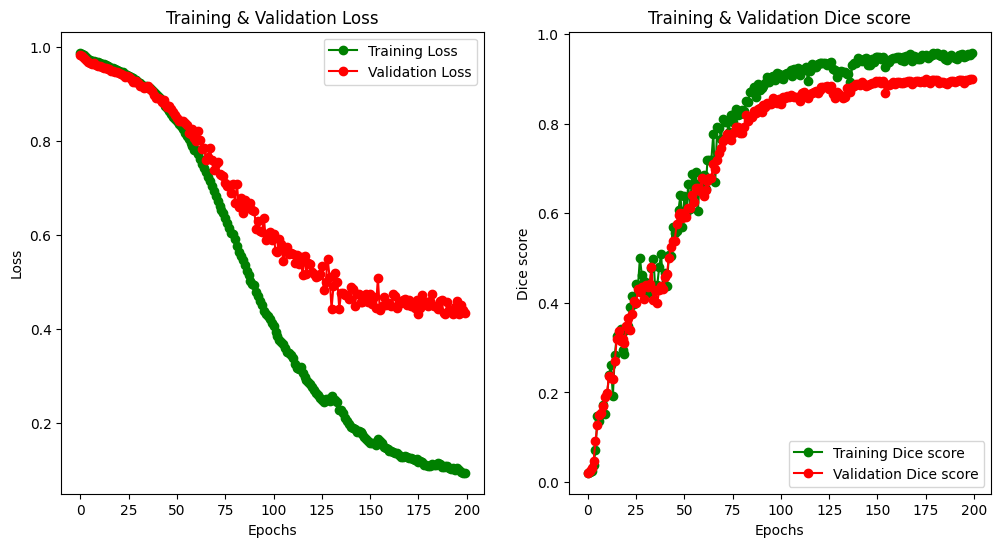

In [19]:
epochs = [i for i in range(len(losses['train']))]
train_loss = losses['train']
val_loss = losses['val']
train_dice = dice_scores['train']
val_dice = dice_scores['val']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax[0].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[0].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , train_dice , 'go-' , label = 'Training Dice score')
ax[1].plot(epochs , val_dice , 'ro-' , label = 'Validation Dice score')
ax[1].set_title('Training & Validation Dice score')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Dice score")

plt.show()

12. visualize the result

In [20]:
pred_dict = {'input':[], 'target':[], 'output':[]}

if MODEL_SAVE:
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, model_name)))

model.to('cpu')
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        img, target = data["image"].cpu(), data["label"].cpu()

        output = model(img).detach().cpu()
        output = torch.argmax(output, dim=1)
        
        pred_dict['input'].append(img)
        pred_dict['target'].append(target)
        pred_dict['output'].append(output)
        
        if i > 10:
            break

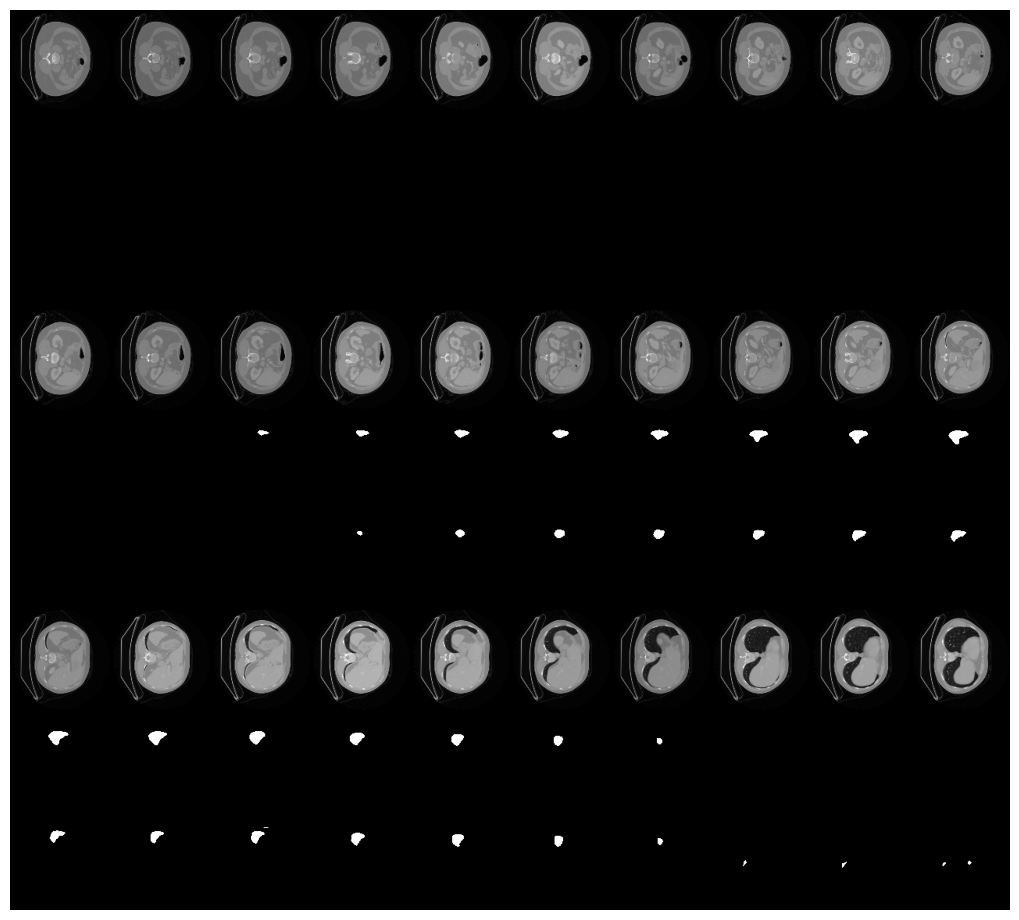

In [21]:
ncols, nrows = 10, 3*3
interval = int(IMAGE_SIZE[-1]//(ncols*nrows/3))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols,nrows))
cnt1, cnt2, cnt3 = 0, 0, 0
for i in range(nrows):
    for j in range(ncols):
        if i%3 == 0:
            axes[i,j].imshow(pred_dict['input'][0][0,0,:,:,cnt1], cmap='gray')
            cnt1+=interval
        elif i%3 == 1:
            axes[i,j].imshow(pred_dict['target'][0][0,0,:,:,cnt2], cmap='gray')
            cnt2+=interval
        else:
            axes[i,j].imshow(pred_dict['output'][0][0,:,:,cnt3], cmap='gray')
            cnt3+=interval
        axes[i,j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()  